In [1]:
import os
import torch
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = "cpu"

/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
df = pd.read_csv('../preprocessed_text/unprocessed_train.csv').sample(frac=1)
df_test = pd.read_csv('../preprocessed_text/unprocessed_test.csv')

df["Verdict"] = df["Verdict"] - 1
df_test["Verdict"] = df_test["Verdict"] - 1

X_train_text = df['Text']
X_test_text = df_test['Text']
y_train = df['Verdict']
y_test = df_test['Verdict']

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

class GPReviewDataset(Dataset):

  def __init__(self, text, verdict, tokenizer, max_len, mask_prob=0.15, mask_token="[MASK]"):
    self.text = text
    self.verdict = verdict
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.mask_prob = mask_prob
    self.mask_token = mask_token
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    verdict = self.verdict[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    rand = torch.rand(encoding['input_ids'].shape)
    mask_arr = (rand < self.mask_prob) & (encoding['input_ids'] != self.tokenizer.cls_token_id) & (encoding['input_ids'] != self.tokenizer.sep_token_id)
    encoding['input_ids'][mask_arr] = self.tokenizer.mask_token_id

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'verdict': torch.tensor(verdict, dtype=torch.long)
    }

In [10]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((43968, 3), (4886, 3), (3000, 3))

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df["Text"].to_numpy(),
    verdict=df["Verdict"].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [12]:
MAX_LEN = 128
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [13]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [8]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
a, b = bert_model(
  return_dict=False,
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
)

print(a.shape, b.shape)

torch.Size([1, 32, 768]) torch.Size([1, 768])


In [17]:
data = next(iter(train_data_loader))
data.keys()

print(data['input_ids'])
print(data['attention_mask'])
print(data['verdict'])
print(tokenizer.convert_ids_to_tokens(data['input_ids'][0]))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4ff42d1120>
Traceback (most recent call last):
Exception ignored in:   File "/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4ff42d1120>
Traceback (most recent call last):
      File "/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  
         ^ ^ ^ ^^^^^^^^^^^^^^^^^
^  File "/home/bizon/miniconda3/envs/project55/lib/python3.12/multiprocessi

tensor([[  101,   103,  1484,  ..., 10515,  1721,   102],
        [  101,   139,  2346,  ...,     0,   103,     0],
        [  101, 20777,   103,  ...,     0,     0,     0],
        ...,
        [  101,  2091,  1128,  ...,  1200,  1303,   102],
        [  101,   103,  1104,  ...,  1342,  1104,   102],
        [  101, 11347, 15152,  ..., 10680,  1219,   102]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([0, 2, 2, 0, 2, 0, 2, 0, 3, 0, 3, 2, 3, 3, 0, 2])
['[CLS]', '[MASK]', 'members', 'at', 'Cross', '##roads', 'Cinema', '[MASK]', 'treated', 'to', 'an', 'unexpected', 'delight', 'Friday', 'when', 'someone', 'in', 'the', 'crowd', 'shouted', 'out', 'a', '[MASK]', '##lar', '[MASK]', '[MASK]', 'at', 'the', 'exact', 'right', '[MASK]', ',', 'sources', 'reported', '[MASK]', "'", 'We', 'were', 'completely', 'blown', 'awa

In [22]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.6)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      return_dict=False,
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)
  

model = SentimentClassifier(4)
model = model.to(device)

EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["verdict"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["verdict"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

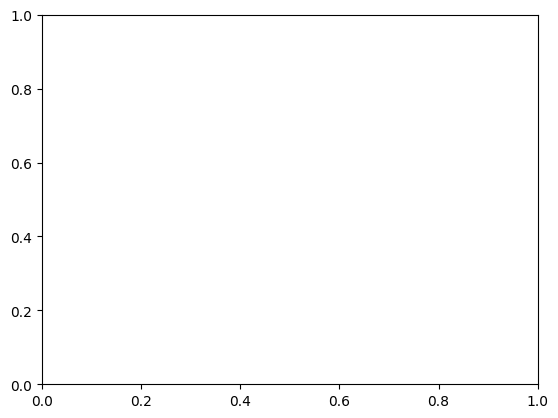

In [16]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [17]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6606666666666666

In [18]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["verdict"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [19]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       750
           1       0.92      0.81      0.86       750
           2       0.19      0.04      0.07       750
           3       0.50      0.98      0.66       750

    accuracy                           0.66      3000
   macro avg       0.62      0.66      0.61      3000
weighted avg       0.62      0.66      0.61      3000



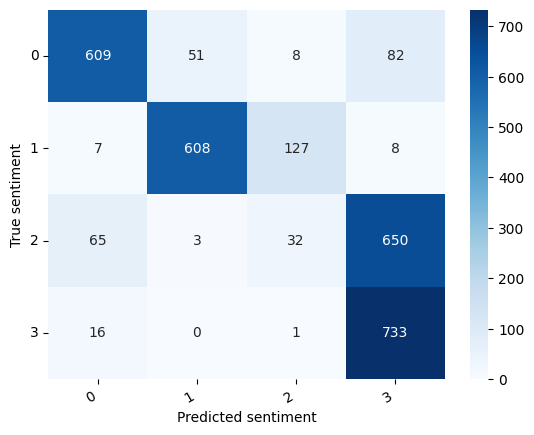

In [20]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)